In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df = pd.read_parquet("../data/processed/window_features_30.parquet")

attacks_df = df[df["label_binary"] == 1].copy()

print("Number of attack windows:", len(attacks_df))


Number of attack windows: 3946


In [3]:
attacks_df.head()
attacks_df["label_multiclass"].unique()

array(['Login', 'GetInfo', 'ListResources', 'CreateObject',
       'AssociateResources', 'Delete', 'Normal', 'ModifyExistingResource',
       'EnableObjects'], dtype=object)

In [4]:
import pandas as pd

def map_specific_events(event_name):
    """
    Maps the specific list of operations to attack categories based on project definitions.
    """
    mapping = {
        # --- Normal ---
        'Normal': 'Normal',
        
        # --- Vulnerability scan (Discovery) ---
        # Based on: "checks the network... generates a lot of API calls to retrieve data"
        'GetInfo': 'Vulnerability scan',
        'ListResources': 'Vulnerability scan',
        
        # --- Cryptojacking ---
        # Based on: "manifests as launching (Create) and terminating (Delete) instances"
        'CreateObject': 'Cryptojacking',
        'Delete': 'Cryptojacking',
        
        # --- Lateral Movement ---
        # Based on: "initial access (Login)", "modifying a flag", "network peering (Associate)"
        'Login': 'Lateral Movement',
        'AssociateResources': 'Lateral Movement',
        'ModifyExistingResource': 'Lateral Movement',
        'EnableObjects': 'Lateral Movement' 
    }
    
    return mapping.get(event_name, 'Other')

# --- בדיקה על הרשימה שלך ---
my_events = ['Login', 'GetInfo', 'ListResources', 'CreateObject',
             'AssociateResources', 'Delete', 'Normal', 'ModifyExistingResource',
             'EnableObjects']

df_results = pd.DataFrame({
    'Event Name': my_events,
    'Attack Category': [map_specific_events(e) for e in my_events]
})

print(df_results)

               Event Name     Attack Category
0                   Login    Lateral Movement
1                 GetInfo  Vulnerability scan
2           ListResources  Vulnerability scan
3            CreateObject       Cryptojacking
4      AssociateResources    Lateral Movement
5                  Delete       Cryptojacking
6                  Normal              Normal
7  ModifyExistingResource    Lateral Movement
8           EnableObjects    Lateral Movement


In [6]:

attacker_profile = (
    attacks_df
    .groupby("userIdentity.userName")
    .agg(
        total_attack_windows=("label_binary", "count"),
        unique_attack_types=("label_multiclass", "nunique"),
        first_seen=("time_window", "min"),
        last_seen=("time_window", "max") 
    )
    .reset_index()
    .sort_values("total_attack_windows", ascending=False)
)

top_attackers = attacker_profile.head(5)
top_attackers


,userIdentity.userName,total_attack_windows,unique_attack_types,first_seen,last_seen
4,backup,1972,6,2017-02-12 21:00:00+00:00,2018-04-17 10:00:00+00:00
3,UNKNOWN_USER,1171,6,2017-02-12 19:30:00+00:00,2023-04-20 20:00:00+00:00
2,Level6,773,4,2017-02-26 23:00:00+00:00,2018-04-16 20:00:00+00:00
7,piper,7,3,2017-05-16 03:30:00+00:00,2018-02-17 22:00:00+00:00
1,Level5,7,2,2017-02-19 23:30:00+00:00,2017-02-23 04:00:00+00:00


In [7]:
# =========================
# Behavioral Attacker Scoring (Unsupervised-style)
# =========================

# Avoid zero-duration
attacker_profile["campaign_duration_days"] = (
    attacker_profile["last_seen"] - attacker_profile["first_seen"]
).dt.days.clip(lower=1)

top_attackers["campaign_duration_days"] = (
    top_attackers["last_seen"] - top_attackers["first_seen"]
).dt.days.clip(lower=1)

# Activity rate
attacker_profile["windows_per_day"] = (
    attacker_profile["total_attack_windows"] /
    attacker_profile["campaign_duration_days"]
)

# Normalize components
for col in [
    "total_attack_windows",
    "unique_attack_types",
    "campaign_duration_days",
    "windows_per_day"
]:
    attacker_profile[f"{col}_norm"] = (
        attacker_profile[col] - attacker_profile[col].mean()
    ) / attacker_profile[col].std()

# Behavioral anomaly score (simple & explainable)
attacker_profile["behavioral_score"] = (
    attacker_profile["total_attack_windows_norm"] +
    attacker_profile["unique_attack_types_norm"] +
    attacker_profile["campaign_duration_days_norm"] +
    attacker_profile["windows_per_day_norm"]
)

# Top attackers by behavior (no labels involved)
top_behavioral_attackers = (
    attacker_profile
    .sort_values("behavioral_score", ascending=False)
    .head(5)
)

top_behavioral_attackers[
    [
        "userIdentity.userName",
        "behavioral_score",
        "total_attack_windows",
        "unique_attack_types",
        "campaign_duration_days",
        "windows_per_day"
    ]
]


/var/folders/xr/2rmpp6y958j29fyql7xwy4p00000gn/T/ipykernel_41141/3555805238.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_attackers["campaign_duration_days"] = (


,userIdentity.userName,behavioral_score,total_attack_windows,unique_attack_types,campaign_duration_days,windows_per_day
4,backup,6.663818,1972,6,428,4.607477
3,UNKNOWN_USER,5.363794,1171,6,2258,0.518601
2,Level6,1.811863,773,4,413,1.871671
1,Level5,-0.728088,7,2,3,2.333333
8,sec-check,-0.974966,2,2,1,2.000000


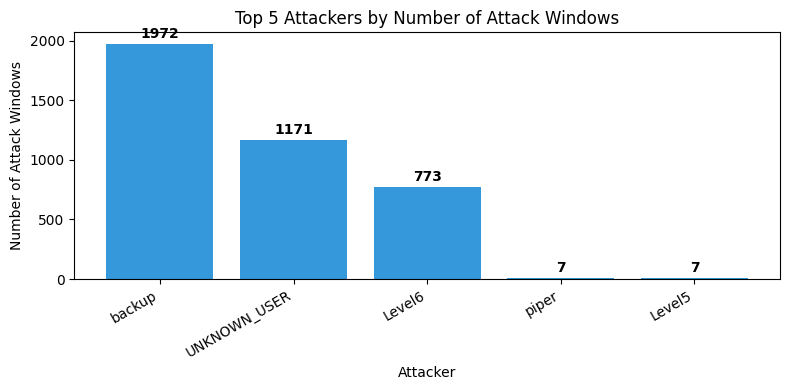

In [8]:
plt.figure(figsize=(8, 4))

# 1. ציור העמודות
plt.bar(
    top_attackers["userIdentity.userName"], 
    top_attackers["total_attack_windows"], # הגובה נקבע לפי כמות ההתקפות
    color='#3498db'
)

plt.ylabel("Number of Attack Windows")
plt.xlabel("Attacker")
plt.title("Top 5 Attackers by Number of Attack Windows")
plt.xticks(rotation=30, ha="right")

# 2. הוספת המספרים (התיקון: שימוש באותו משתנה כמו העמודות)
for i, v in enumerate(top_attackers["total_attack_windows"]):
    plt.text(
        i,              # מיקום אופקי (מרכז העמודה)
        v + 50,         # מיקום אנכי (קצת מעל העמודה)
        str(int(v)),    # הטקסט להצגה
        ha='center',    # יישור למרכז
        fontweight='bold'
    )

plt.tight_layout()
plt.show()

In [9]:
top_attackers.columns


Index(['userIdentity.userName', 'total_attack_windows', 'unique_attack_types',
       'first_seen', 'last_seen', 'campaign_duration_days'],
      dtype='object')

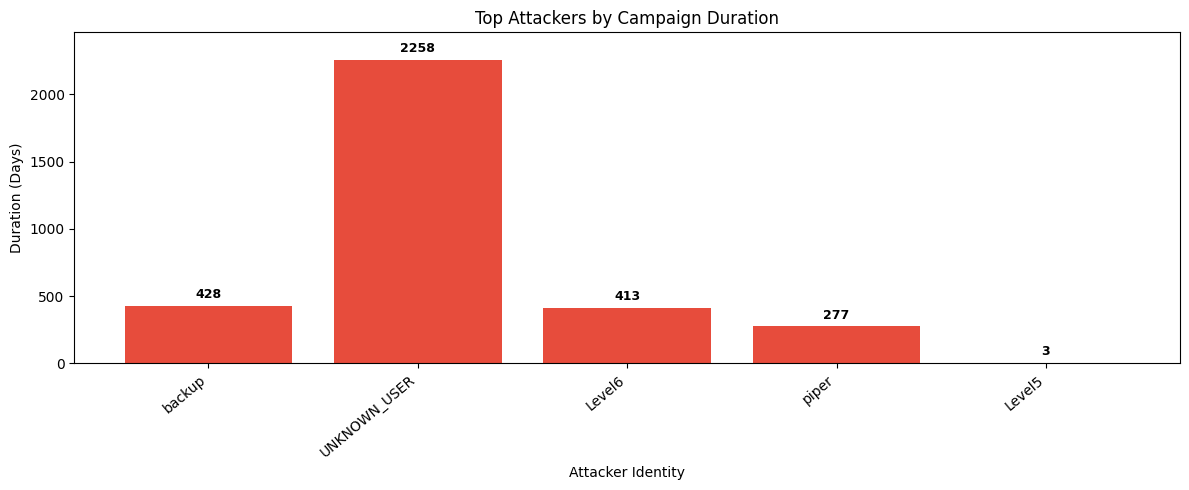

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 5))

bars = ax.bar(
    top_attackers["userIdentity.userName"],
    top_attackers["campaign_duration_days"],
    color="#e74c3c"
)

ax.set_title("Top Attackers by Campaign Duration")
ax.set_ylabel("Duration (Days)")
ax.set_xlabel("Attacker Identity")

# סיבוב ויישור שמות
ax.tick_params(axis="x", rotation=40)
plt.setp(ax.get_xticklabels(), ha="right")

# הוספת ערכים מעל העמודות (הזחה חכמה)
max_v = top_attackers["campaign_duration_days"].max()
offset = max(1, max_v * 0.015)

for bar in bars:
    h = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        h + offset,
        f"{int(h)}",
        ha="center",
        va="bottom",
        fontsize=9,
        fontweight="bold"
    )

ax.set_ylim(0, max_v + 6 * offset)
plt.tight_layout()
plt.show()


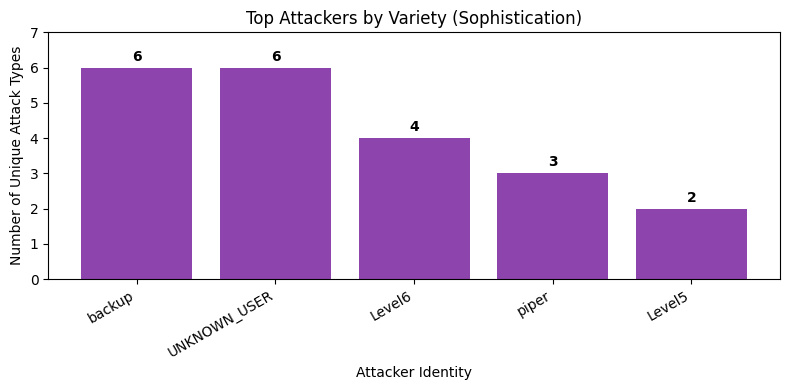

In [11]:
plt.figure(figsize=(8, 4))
plt.bar(
    top_attackers["userIdentity.userName"], 
    top_attackers["unique_attack_types"],
    color='#8e44ad' # סגול - מסמל תחכום
)

plt.ylabel("Number of Unique Attack Types")
plt.title("Top Attackers by Variety (Sophistication)")
plt.xlabel("Attacker Identity")
plt.xticks(rotation=30, ha="right")
plt.yticks(range(0, 8)) # סקאלה של מספרים שלמים כי זה כמות סוגים

# הוספת מספרים
for i, v in enumerate(top_attackers["unique_attack_types"]):
    plt.text(i, v + 0.2, str(int(v)), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

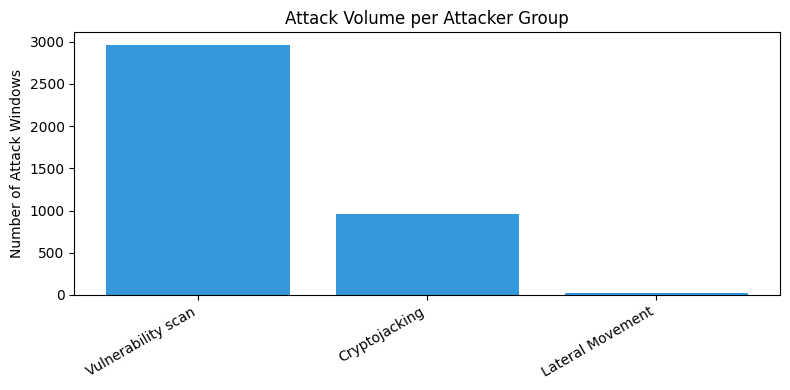

In [12]:
# 1. מיפוי לקבוצות (הקוד הקיים שלך)
attacks_df["attacker_group"] = attacks_df["label_multiclass"].apply(map_specific_events)

# --- התיקון: סינון שורות שהן Normal ---
attacks_df = attacks_df[attacks_df["attacker_group"] != 'Normal']

# 2. חישוב הכמויות (הקוד הקיים שלך)
group_volume = (
    attacks_df
    .groupby("attacker_group")
    .size()
    .sort_values(ascending=False)
)

# 3. ציור הגרף
plt.figure(figsize=(8, 4))
plt.bar(group_volume.index, group_volume.values, color='#3498db') # הוספתי צבע כחול יפה
plt.ylabel("Number of Attack Windows")
plt.title("Attack Volume per Attacker Group")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

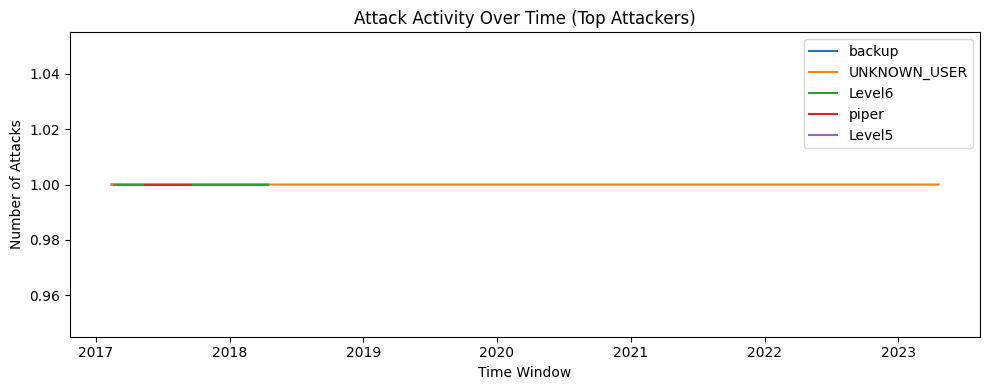

In [13]:
timeline = (
    attacks_df
    .groupby(["time_window", "userIdentity.userName"])
    .size()
    .reset_index(name="num_attacks")
)

plt.figure(figsize=(10,4))
for user in top_attackers["userIdentity.userName"]:
    data = timeline[timeline["userIdentity.userName"] == user]
    plt.plot(data["time_window"], data["num_attacks"], label=user)

plt.legend()
plt.title("Attack Activity Over Time (Top Attackers)")
plt.xlabel("Time Window")
plt.ylabel("Number of Attacks")
plt.tight_layout()
plt.show()


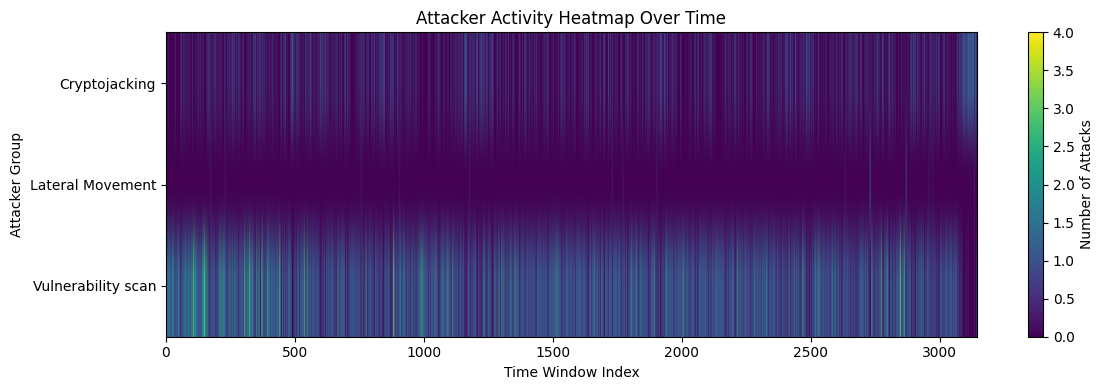

In [14]:
timeline_grouped = (
    attacks_df
    .groupby(["attacker_group", "time_window"])
    .size()
    .reset_index(name="count")
)

pivot = timeline_grouped.pivot(
    index="attacker_group",
    columns="time_window",
    values="count"
).fillna(0)

plt.figure(figsize=(12,4))
plt.imshow(pivot, aspect="auto")
plt.yticks(range(len(pivot.index)), pivot.index)
plt.colorbar(label="Number of Attacks")
plt.title("Attacker Activity Heatmap Over Time")
plt.xlabel("Time Window Index")
plt.ylabel("Attacker Group")
plt.tight_layout()
plt.show()


/var/folders/xr/2rmpp6y958j29fyql7xwy4p00000gn/T/ipykernel_41141/631233959.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=yearly_counts.index, y=yearly_counts.values, palette='viridis')


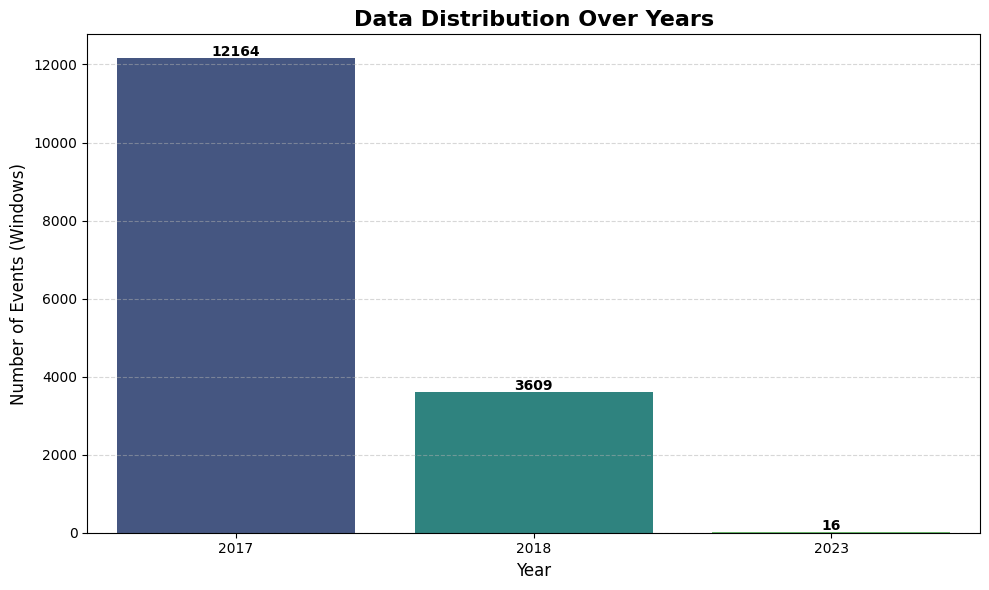

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. המרה לפורמט תאריך (למקרה שזה עדיין לא)
df['time_window'] = pd.to_datetime(df['time_window'])

# 2. חילוץ השנה וספירת הכמויות
yearly_counts = df['time_window'].dt.year.value_counts().sort_index()

# 3. יצירת הגרף
plt.figure(figsize=(10, 6))
sns.barplot(x=yearly_counts.index, y=yearly_counts.values, palette='viridis')

# עיצוב
plt.title('Data Distribution Over Years', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Events (Windows)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# הוספת המספרים מעל העמודות
for i, v in enumerate(yearly_counts.values):
    plt.text(i, v + 50, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

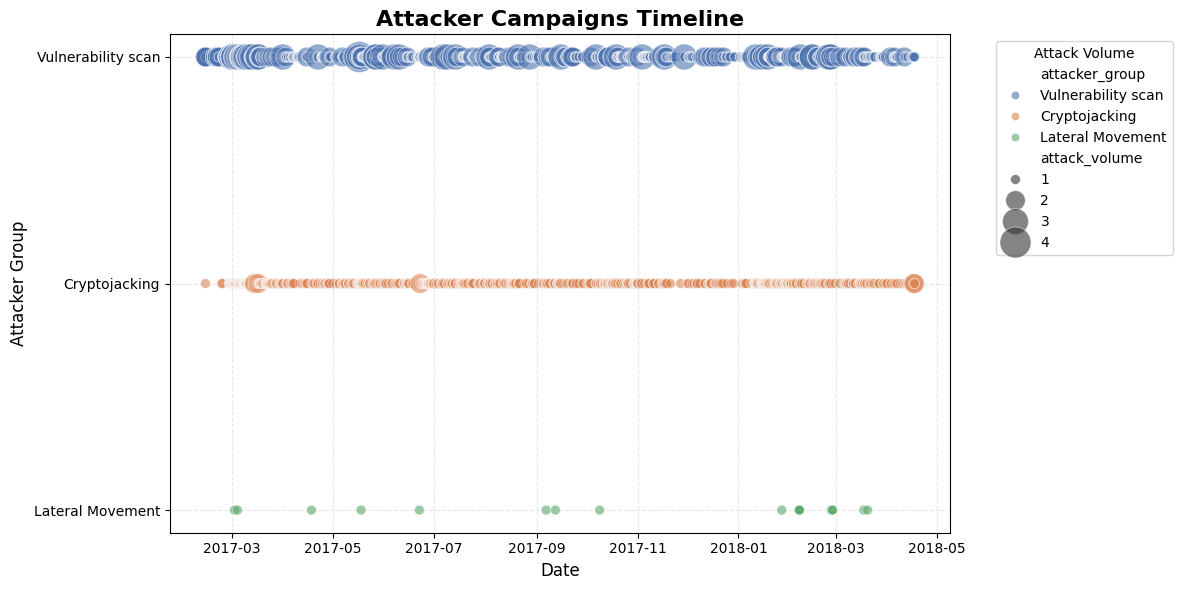

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. הכנת הנתונים (עם סינון כפול: בלי Normal ורק עד 2020)
# אנו מניחים ש-time_window הוא בפורמט datetime. אם לא, כדאי להמיר קודם: pd.to_datetime(attacks_df['time_window'])

bubble_data = (
    attacks_df[
        (attacks_df["attacker_group"] != 'Normal') & 
        (attacks_df["time_window"] < '2021-01-01')  # <--- הפילטר החדש: הכל לפני 2021
    ]
    .groupby(["time_window", "attacker_group"])
    .size()
    .reset_index(name="attack_volume")
)

# 2. יצירת הגרף (אותו דבר כמו קודם)
plt.figure(figsize=(12, 6))

sns.scatterplot(
    data=bubble_data,
    x="time_window",
    y="attacker_group",
    size="attack_volume",
    hue="attacker_group",
    sizes=(50, 500),
    alpha=0.6,
    palette="deep"
)

plt.title('Attacker Campaigns Timeline', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Attacker Group', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Attack Volume")
plt.tight_layout()

plt.show()

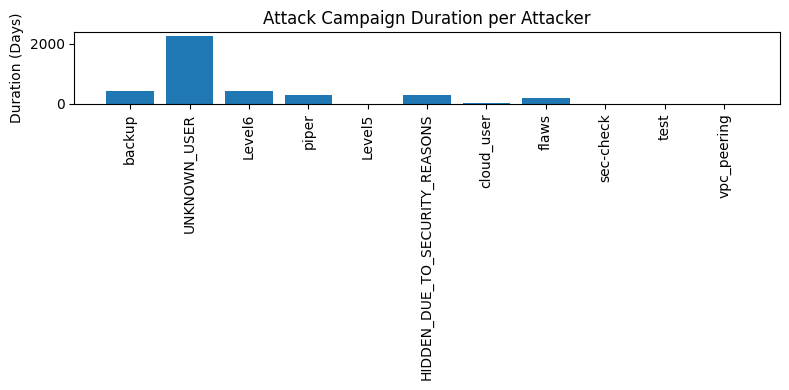

In [17]:
attacker_profile["campaign_duration_days"] = (
    attacker_profile["last_seen"] - attacker_profile["first_seen"]
).dt.days

plt.figure(figsize=(8,4))
plt.bar(
    attacker_profile["userIdentity.userName"],
    attacker_profile["campaign_duration_days"]
)
plt.xticks(rotation=90)
plt.ylabel("Duration (Days)")
plt.title("Attack Campaign Duration per Attacker")
plt.tight_layout()
plt.show()


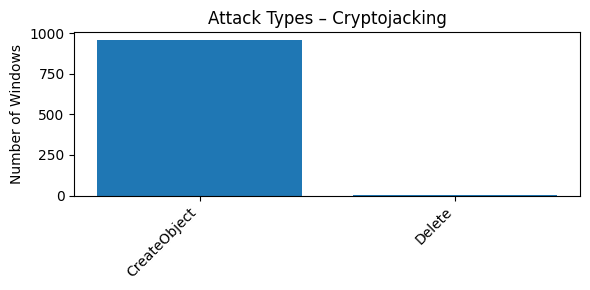

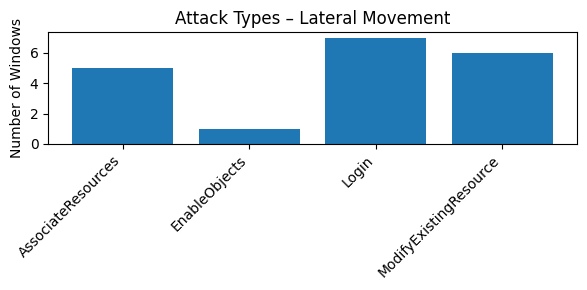

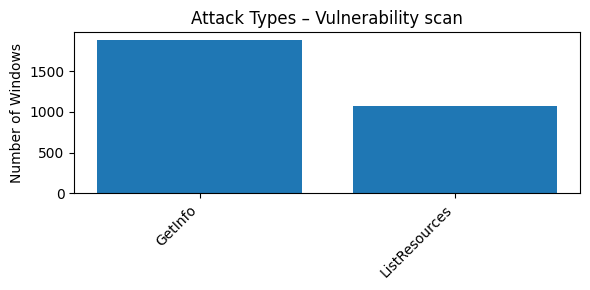

In [18]:
attack_type_by_group = (
    attacks_df
    .groupby(["attacker_group", "label_multiclass"])
    .size()
    .reset_index(name="count")
)

for group in attack_type_by_group["attacker_group"].unique():
    data = attack_type_by_group[attack_type_by_group["attacker_group"] == group]
    
    plt.figure(figsize=(6,3))
    plt.bar(data["label_multiclass"], data["count"])
    plt.xticks(rotation=45, ha="right")
    plt.title(f"Attack Types – {group}")
    plt.ylabel("Number of Windows")
    plt.tight_layout()
    plt.show()


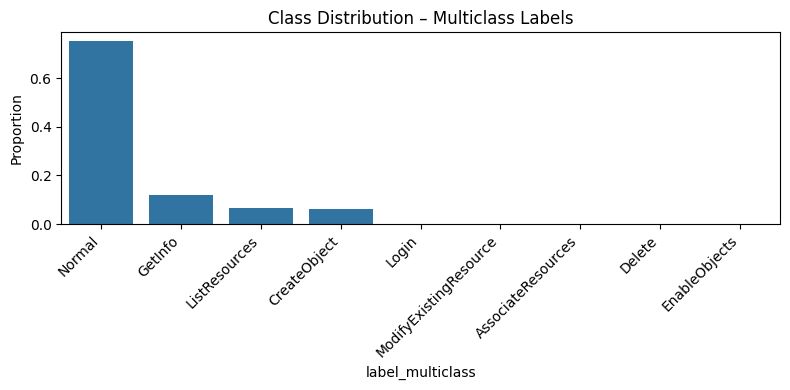

In [19]:
class_dist = (
    df["label_multiclass"]
    .value_counts(normalize=True)
)

plt.figure(figsize=(8,4))
sns.barplot(x=class_dist.index, y=class_dist.values)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Proportion")
plt.title("Class Distribution – Multiclass Labels")
plt.tight_layout()
plt.show()


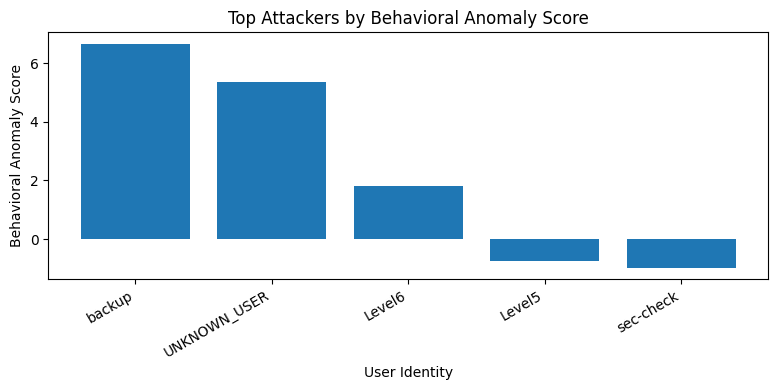

In [20]:
plt.figure(figsize=(8,4))
plt.bar(
    top_behavioral_attackers["userIdentity.userName"],
    top_behavioral_attackers["behavioral_score"]
)
plt.ylabel("Behavioral Anomaly Score")
plt.xlabel("User Identity")
plt.title("Top Attackers by Behavioral Anomaly Score")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()
